# Heterogeneity study

We study the results from notebook 2, and will try to emphasize heterogeities in the result. We will also conduct some tests to test the strength of our results. 

In [1]:
%matplotlib inline
from script import plot_conf, to_date
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from os import path

In [2]:
# Data folders
data_folder = "data/" 
result_folder = "results/"

In [3]:
df = pd.read_csv( path.join( result_folder, 'AR.csv'))
df = df.drop_duplicates(subset = ['ISIN'])

# We only keep the anormal returns, not the errors
def is_float(str):
    try :
        float(str)
        return True
    except :
        return False

filter = np.all([[is_float(df[f'AR_{2*j}'].iloc[i]) for i in range(len(df))] for j in range(5,16)], axis = 0)
df = df[filter]
df[ df.columns[1:] ] = df[ df.columns[1:] ].apply(pd.to_numeric)



### Strength test

The main source of error with the market model is that the abnormal return may vary with the time window used for the linear regression. We have : $AR = AR(i,t)$ where i is the event and t is the time window used for the linear regression. Here we want to see if we can define an abnormal return so that $AR = AR(i)$. Morerover, we want see if 
$AR(i) = \mathbb{E} (AR(i,t))$ could be relevant.

We will study the disparities in our results to see if they depend or not of the time period used for the linear regression. We want to see if the different abnormal return are close or not of the average abnormal return for one firm. We also want to see the standard deviation of our results. The goal is to see if it can be releavant to keep the average abnormal return for each firm for further studies.

In [4]:
#Standard deviation
Sigma = np.array([np.std(df.iloc[i][1:]) for i in range(len(df))])
print(f'Average standart deviation : {np.mean(Sigma)}')


Average standart deviation : 0.23245143999761525


We will represent the repartition of standard deviation, to see how many results present an important standard deviation

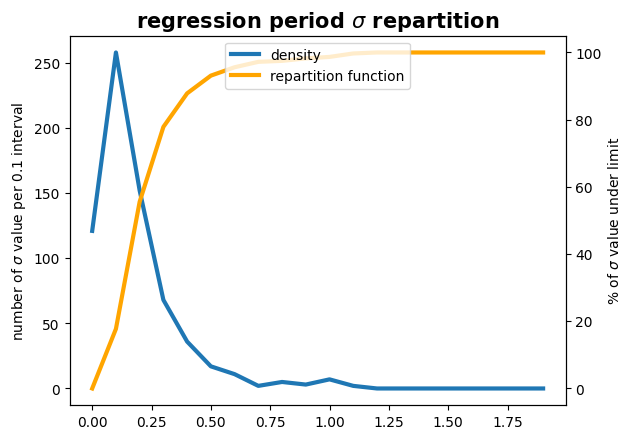

In [5]:
Sigma_density = np.array([np.sum(np.logical_and(Sigma < 0.1*(i+1) , Sigma >=  0.1*i)) for i in range(20)])
Sigma_inf_percentage = np.array([ np.sum( Sigma< 0.1*i)*100/len(Sigma) for i in range(20)])
x = np.array([ 0.1 * i  for i in range(20)])

fig, ax = plt.subplots()
ax.plot(x, Sigma_density, linewidth = 3)
ax.set_ylabel('number of $\sigma$ value per 0.1 interval')


ax2 = ax.twinx()
ax2.plot(x, Sigma_inf_percentage,  color = 'orange', linewidth = 3)
ax2.set_ylabel('$\%$ of $\sigma$ value under limit')

lines = [ax.get_lines()[0], ax2.get_lines()[0]]
plt.legend(lines, ['density', 'repartition function'], loc="upper center")
plt.title('regression period $\sigma$ repartition', fontsize = 15 , fontweight = 'semibold')
#plt.savefig(path.join(result_folder, 'sigma_repartition.png' ))
plt.show();

If we only keep the results where $\sigma < 1$, we will still have more than 98% of the data, while eliminating anormal values. 

In [6]:
filter = Sigma < 1
df_filtered = df[filter]
new_Sigma = Sigma[filter]
frac = np.round( (len(df_filtered)/ len(df))*100, 2)
print(f'Percentage of data kept : {frac} %')

Percentage of data kept : 98.68 %


C:\Users\alexa\AppData\Local\Temp\ipykernel_6460\2877554028.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  average = df_filtered.mean()


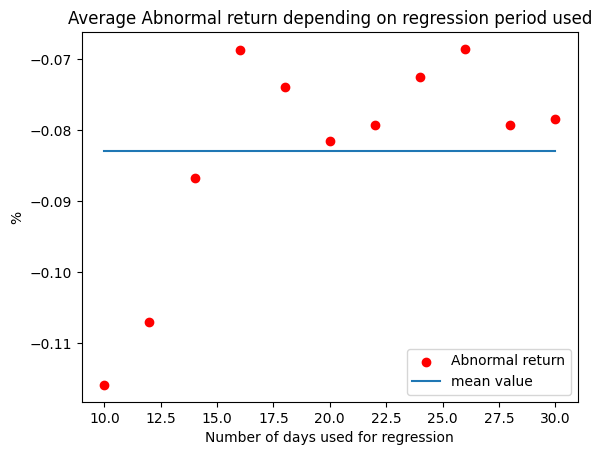

In [20]:
average = df_filtered.mean()
Average = average.mean()*np.ones(11)

x = range(10, 31, 2)
plt.scatter(x, average, color = 'red', label = 'Abnormal return')
plt.xlabel('Number of days used for regression')
plt.plot(x, Average, label='mean value' )
plt.legend()
plt.ylabel('%')
plt.title('Average Abnormal return depending on regression period used')
#plt.savefig(path.join(result_folder, 'variation_regression_time.png' ))
plt.show();

The average value of abnormal returns depends of the number of days used for regression, but remain close to the mean one, and is negative in average

In [8]:
# New average and min/max values
AR_mean = np.array([ np.mean(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])
AR_max = np.array([ np.max(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])
AR_min = np.array([ np.min(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])

We will compare the average abnormal return with the min and max values

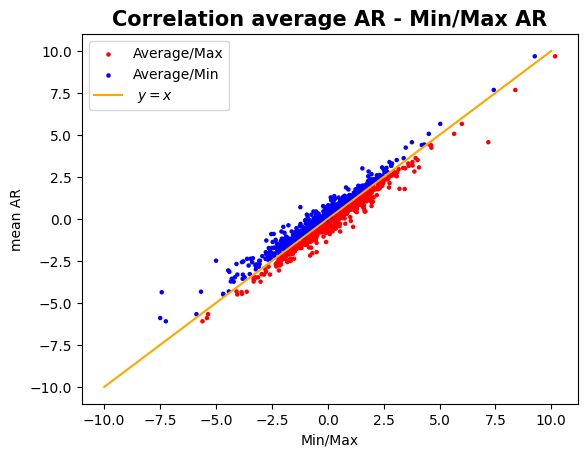

In [9]:
plt.figure()
s = [ 5 for i in range(len(AR_max))] #marker size
plt.scatter(AR_max, AR_mean, s = s, color = 'red' , label = 'Average/Max')
plt.scatter(AR_min, AR_mean, s = s, color = 'blue' , label = 'Average/Min')
plt.plot([-10, 10] , [-10, 10] , color ='orange', label = ' $y = x$')
plt.xlabel('Min/Max')
plt.ylabel('mean AR')
plt.title('Correlation average AR - Min/Max AR', fontweight = 'semibold' , fontsize = 15)
plt.legend()
#plt.savefig(path.join(result_folder, 'correlation.png'))
plt.show();


The results depends on the time period used for regression, but are all close to the average value. 

 ### For the rest of the noteboook, we will focus on $AR(i) = \mathbb{E}(AR(i,t))$


# Result study

In [21]:
print(f'average abnormal return : {np.mean(AR_mean)} %')

average abnormal return : -0.08288723495354797 %


The first we notice is that the global effect is **negative**, but **close to 0** $( \approx  - 0.08 \%)$
This value can depends on the time period used  for the regression, but as we saw, it always remain negative. 

We will now try to reveal heterogenities

In [11]:
# We will need more informations about the companies
info = pd.read_csv(path.join(data_folder, 'info.csv') , sep =';', encoding= 'latin_1') 

info = info.drop_duplicates(subset = ['ISIN'])
info = info[info['ISIN'].notna()].set_index('ISIN')



In [12]:
# infos
isin = np.array(df_filtered['ISIN'])
sector = np.array([info.loc[i]['Sector'] for i in isin])
company_type = np.array([info.loc[i]['Organization type'] for i in isin])
continent =  np.array([info.loc[i]['Region '] for i in isin])
date = np.array([info.loc[i]['Region '] for i in isin])
target = np.array([info.loc[i]['Target'] for i in isin])
date = np.array([info.loc[i]['Date published'] for i in isin])
target_value = np.array([info.loc[i]['Target value'] for i in isin])

# Average
AR_mean = np.array([ np.mean(df_filtered.iloc[i][1:]) for i in range(len(df_filtered))])


**Impact of type**

In [13]:
new_df = pd.DataFrame({'type' : company_type, 'AR' : AR_mean })
g =(new_df.groupby( 'type')).mean()
s =  (new_df.groupby( 'type')).size()


groups = new_df.groupby('type')
Sigma = []
for group in groups:
    sigma = np.std(group[1]['AR'])
    Sigma.append(sigma)

sigma = pd.DataFrame({'Sigma' : Sigma }).set_index(g.index)
r = pd.concat([g, s, sigma], axis = 1)
r = r.rename( columns = { 0 : 'size'})
conf_90 = r['Sigma']/(r['size'])**0.5
conf_90_inf = r['AR'] - conf_90
conf_90_sup = r['AR'] + conf_90
r['Conf_90_inf'] = conf_90_inf # 90 percent confidency interval
r['Conf_90_sup'] = conf_90_sup 

print(r)

                                  AR  size     Sigma  Conf_90_inf  Conf_90_sup
type                                                                          
Company                    -0.074306   622  1.472084    -0.133331    -0.015281
Financial Institution      -0.067924     8  1.203060    -0.493270     0.357421
Small or Medium Enterprise -0.209801    43  2.253265    -0.553421     0.133818



**Impact of sector**

In [14]:
new_df = pd.DataFrame({'sector' : sector, 'AR' : AR_mean })
g = (new_df.groupby( 'sector')).mean()
s = (new_df.groupby( 'sector')).size()
r = pd.concat([g, s], axis = 1)
r = r.rename( columns = {'AR': 'AR' , 0 : 'size'})
print(r)

                                                          AR  size
sector                                                            
Aerospace and Defense                               0.166455     1
Air Freight Transportation and Logistics           -0.378192     9
Air Transportation - Airlines                      -0.879373     4
Automobiles and Components                          0.107592    21
Banks, Diverse Financials, Insurance               -0.067924     8
Building Products                                  -0.335102    14
Chemicals                                           0.582622    15
Construction Materials                             -0.199610     9
Construction and Engineering                        0.012058    29
Consumer Durables, Household and Personal Products  0.717819    40
Containers and Packaging                           -0.055546    12
Education Services                                 -0.847651     2
Electric Utilities and Independent Power Produc... -0.480155  

**Impact of geographical origin**

In [15]:
new_df = pd.DataFrame({'Continent' : continent, 'AR' : AR_mean })
g =(new_df.groupby('Continent')).mean()
s =  (new_df.groupby( 'Continent')).size()
r = pd.concat([g, s], axis = 1)
r = r.rename( columns = { 0 : 'size'})
print(r)


                                       AR  size
Continent                                      
Asia                             0.033067   126
Europe                          -0.157456   356
Latin America and the Caribbean -0.043421     8
Northern America                -0.015154   175
Oceania                         -0.111959     8


**We will plot the confidency intervals**

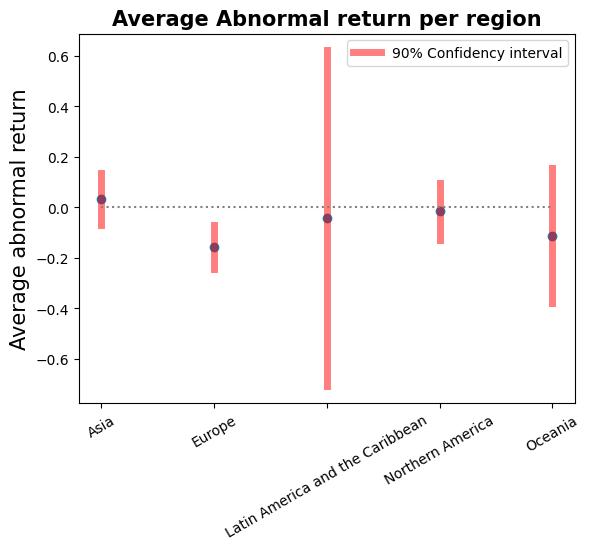

In [22]:
new_df = pd.DataFrame({'Continent' : continent , 'AR' : AR_mean})
groups = new_df.groupby('Continent')

Sigma = []
for group in groups:
    sigma = np.std(group[1]['AR'])
    Sigma.append(sigma)

g =(new_df.groupby('Continent')).mean()
s =  (new_df.groupby( 'Continent')).size()
sigma = pd.DataFrame({'Sigma' : Sigma }).set_index(g.index)
r = pd.concat([g, s, sigma], axis = 1)
r = r.rename( columns = { 0 : 'size'})

conf_90 = r['Sigma']/(r['size'])**0.5
conf_95 = 2*conf_90
r['Conf_90'] = conf_90 # 90 percent confidency term
r['Conf_95'] = conf_95 # 95 percent confidency term (if needed)

plt.scatter(r.index, r['AR'])
plot_conf(r.index, r['Conf_90'], r['AR'], label ='90% Confidency interval')
#plot_conf(r.index, r['Conf_95'], r['AR'], label ='95% Confidency interval', color = 'orange')
plt.plot(r.index, [0 for i in range(len(r.index))], linestyle = ':', color = 'gray')
plt.xticks( rotation = 30)
plt.legend()
plt.ylabel('Average abnormal return', fontsize = 15)
plt.title('Average Abnormal return per region', fontsize = 15, fontweight = 'demibold')
#plt.savefig(path.join(result_folder, 'region_impact.png' ))
plt.show();

We have enought firms in Europe,  average AR for Europe is significant enought to conclude a **negative** effect of emission mitigation release in Europe. Conversly, the average effect in Northern America and Asia is close to 0. Due to the small amounts of firms in Oceania and Latin America, we cannot give any conclusion.

**Impact of date**

We want to see if the date had an impact on the perception

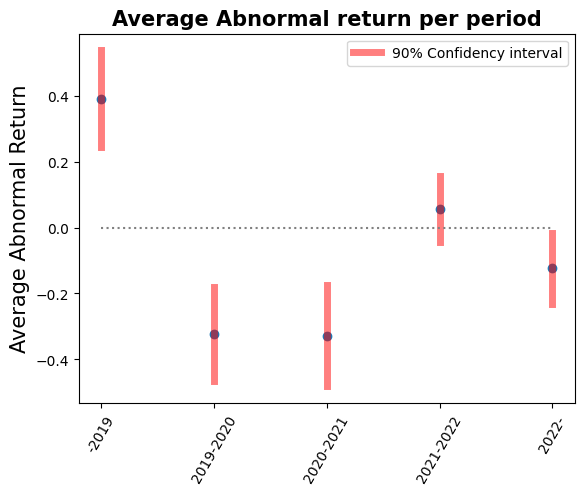

In [23]:
date2 = to_date(date)
ante_2019 = date2 < to_date('01/01/2019')
btw_2019_2020 = np.logical_and( date2 < to_date('01/01/2020') ,  date2 >= to_date('01/01/2019') )
btw_2020_2021 = np.logical_and( date2 < to_date('01/01/2021') ,  date2 >= to_date('01/01/2020') )
btw_2021_2022 = np.logical_and( date2 < to_date('01/01/2022') ,  date2 >= to_date('01/01/2021') )
post_2022 = date2 >= to_date('01/01/2022')

ante_2019 = AR_mean[ante_2019]
btw_2019_2020 = AR_mean[btw_2019_2020]
btw_2020_2021 = AR_mean[btw_2020_2021]
btw_2021_2022 = AR_mean[btw_2021_2022]
post_2022 = AR_mean[post_2022]

Mean = np.array([ante_2019.mean(), btw_2019_2020.mean(), btw_2020_2021.mean(), 
                 btw_2021_2022.mean(), post_2022.mean()])
Sigma = np.array([np.std(ante_2019), np.std(btw_2019_2020), np.std(btw_2020_2021), 
                  np.std(btw_2021_2022), np.std(post_2022)])
Size = np.array([ len(ante_2019), len(btw_2019_2020), len(btw_2020_2021), len(btw_2021_2022), len(post_2022)])
Conf_90 = Sigma/(Size)**0.5

index = ['-2019', '2019-2020', '2020-2021', '2021-2022', '2022-']
plt.scatter(index, Mean)
plot_conf(index, Conf_90, Mean, label ='90% Confidency interval')
plt.plot(index, [0 for i in range(len(index))], linestyle = ':', color = 'gray')
plt.xticks( rotation = 60)
plt.ylabel('Average Abnormal Return', fontsize = 15)
plt.legend()
plt.title('Average Abnormal return per period', fontsize = 15, fontweight = 'demibold')
#plt.savefig(path.join(result_folder, 'date_impact.png' ))
plt.show();


**Impact of target type**

On the list of companies we studied, we have two types of targets, the net-zero one and the near term reduction one.

In [18]:
target_list = np.unique(target)
print(target_list)
near_term = AR_mean[target == target_list[0]]
net_zero = AR_mean[target == target_list[1]]
Sigma = np.array([np.std(near_term), np.std(net_zero)])
Mean = np.array([near_term.mean(), net_zero.mean()])
Size = np.array([len(near_term), len(net_zero)])
Conf_90 = Sigma/((Size)**0.5)
Inf = Mean - Conf_90
Sup = Mean + Conf_90

new_df = pd.DataFrame({'AR' : Mean, '90_conf_inf' : Inf, '90_conf_sup' : Sup, 'Size' : Size}).set_index(target_list)
print(new_df)

['Near-term' 'Net-zero']
                 AR  90_conf_inf  90_conf_sup  Size
Near-term -0.086336    -0.145641    -0.027031   667
Net-zero   0.300518    -0.299049     0.900084     6


Due to the small size of the dataset, we canot conclude in a postive effect of net-zero claims

**Impact of target value**

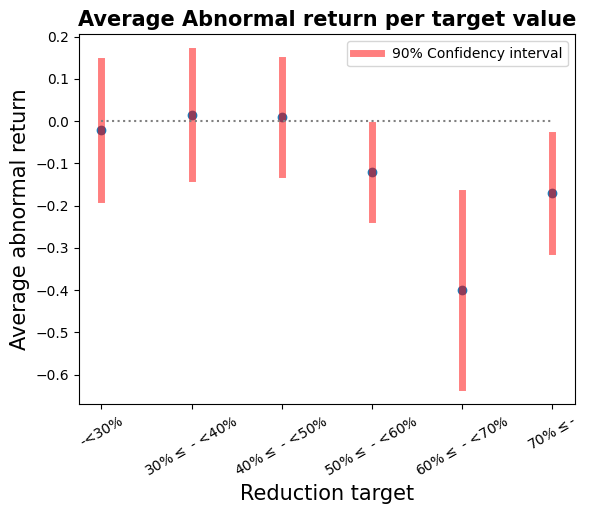

In [24]:
nan_filter = np.array([ t != 'nan' and t != 'na' for t in target_value])
target_value_new = target_value[nan_filter]
Mean = AR_mean[nan_filter]

def to_numeric(str):
    return int(str[:-1])
to_numeric = np.vectorize(to_numeric)
target_value_new = to_numeric(target_value_new)

inf_30 = target_value_new < 30
sup_70 = target_value_new >= 70
btw30_40 = np.logical_and( target_value_new >= 30 , target_value_new <40)
btw40_50 = np.logical_and( target_value_new >= 40 , target_value_new <50)
btw50_60 = np.logical_and( target_value_new >= 50 , target_value_new <60)
btw60_70 = np.logical_and( target_value_new >= 60 , target_value_new <70)

inf_30 = Mean[inf_30]
sup_70 = Mean[sup_70]
btw30_40 = Mean[btw30_40]
btw40_50 = Mean[btw40_50]
btw50_60 = Mean[btw50_60]
btw60_70 = Mean[btw60_70]

l = [inf_30, btw30_40, btw40_50, btw50_60, btw60_70, sup_70]
Mean = np.array([var.mean() for var in l])
Size = np.array([len(var) for var in l])
Sigma = np.array([np.std(var) for var in l])
Conf_90 = Sigma/((Size)**0.5)

index = [ '-<30%', '30%$\leq$ - <40%', '40%$\leq$ - <50%', '50%$\leq$ - <60%', '60%$\leq$ - <70%', '70%$\leq$-' ]
plt.scatter(index, Mean)
plot_conf(index, Conf_90, Mean, label ='90% Confidency interval')
plt.plot(index, [0 for i in range(len(index))], linestyle = ':', color = 'gray')
plt.xticks( rotation = 30)
plt.legend()
plt.ylabel('Average abnormal return', fontsize = 15)
plt.xlabel('Reduction target', fontsize = 15)
plt.title('Average Abnormal return per target value', fontsize = 15, fontweight = 'demibold')
#plt.savefig(path.join(result_folder, 'target_value_impact.png' ))
plt.show();





Here we have a clear effect : strong reduction tend to scare the investors